I've been reading the book [Doing Bayesian Data Analysis](https://www.amazon.com/Doing-Bayesian-Data-Analysis-Tutorial/dp/0124058884), and there is an example there with baseball, which I'd like to try for football.

Basically, we want to estimate what's the probability of a player scoring in a match, and which part of that probability is influenced by their position on the field vs other factors. We'll focus on Neymar but I'm actually using the data of all players from UEFA Champions League.

First let's load our data. I collected data from UEFA Champions League for 2018 and 2019-2020, each row is a participation of a player in a match, with which position they were on this match, and how much goals they scored. Players that were in substitution bench during the match but never entered the field are not included

In [472]:
import pandas as pd
import numpy as np

df = pd.read_csv("uefa_player_matches.csv", parse_dates=["match_date"])
df = df.dropna()
df = df[df['position'].isin(["G", "D", "M", "F"])] # excluded "SUB" and "-" positions
position_map = {'G': 'Goalkeeper', 'D': 'Defender', 'M': 'Midfield', 'F': 'Forward'}
df['position'] = [ position_map[x] for x in df['position'] ]
df.head()

,match_id,match_date,player,player_id,team,team_id,position,goals
0,158963,2019-06-25 13:00:00+00:00,Mattia Migani,80722.0,Tre Penne,700,Goalkeeper,0
1,158963,2019-06-25 13:00:00+00:00,Davide Cesarini,56095.0,Tre Penne,700,Defender,0
4,158963,2019-06-25 13:00:00+00:00,Mirko Palazzi,56099.0,Tre Penne,700,Defender,0
5,158963,2019-06-25 13:00:00+00:00,Nicola Gai,80723.0,Tre Penne,700,Midfield,0
7,158963,2019-06-25 13:00:00+00:00,Nicola Chiaruzzi,80724.0,Tre Penne,700,Midfield,0


Let's take a look on matches that Neymar participated

In [473]:
df[df['player'] == 'Neymar']

,match_id,match_date,player,player_id,team,team_id,position,goals
4360,240579,2019-11-26 20:00:00+00:00,Neymar,276.0,Paris Saint Germain,85,Forward,0
5012,240603,2019-12-11 20:00:00+00:00,Neymar,276.0,Paris Saint Germain,85,Midfield,1
5192,292852,2020-02-18 20:00:00+00:00,Neymar,276.0,Paris Saint Germain,85,Forward,1
5451,292853,2020-03-11 20:00:00+00:00,Neymar,276.0,Paris Saint Germain,85,Midfield,1
5610,570966,2020-08-12 19:00:00+00:00,Neymar,276.0,Paris Saint Germain,85,Forward,0
5698,589000,2020-08-18 19:00:00+00:00,Neymar,276.0,Paris Saint Germain,85,Forward,0
5731,591151,2020-08-23 19:00:00+00:00,Neymar,276.0,Paris Saint Germain,85,Forward,0
8419,39151,2018-09-18 19:00:00+00:00,Neymar,276.0,Paris Saint Germain,85,Forward,0
8930,39170,2018-10-03 16:55:00+00:00,Neymar,276.0,Paris Saint Germain,85,Forward,3
9504,39191,2018-10-24 19:00:00+00:00,Neymar,276.0,Paris Saint Germain,85,Forward,0


Just to help us understand our data a bit, what's the distribution of goals per match?

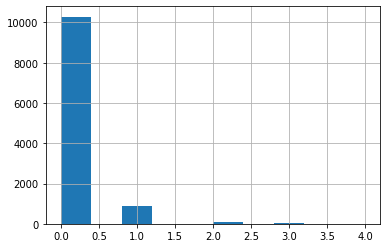

In [478]:
df['goals'].hist();

Woah a Poisson distribution as expected, I love those. Okay and which positions scores more?

In [479]:
df[['position', 'goals']].groupby('position').sum()

,goals
position,
Defender,135
Forward,587
Goalkeeper,3
Midfield,449


Alright zero surprises so far. Let's move on and build a Logistic Regression model, which will give us a probability of a goal given a player and their position.

In [480]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

X = df[['player_id', 'position']]
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(X)
X = one_hot_encoder.transform(X)

y = [ 1 if y > 0 else 0 for y in df['goals'] ]

model = LogisticRegression()
model.fit(X, y)
model.score(X, y)

0.9107711354793067

Logistic regression can fit our data with 91% accuracy, seems pretty good. Now let's take a look on what's the probability of Neymar scoring a goal in some future match:

$$
P(goal | neymar,forward )
$$

In [530]:
neymar_id = 276
X_example = one_hot_encoder.transform([[ neymar_id, "Forward" ]])
model.predict_proba(X_example)[0][1]

0.3835193670312905

38%, not bad, what if Neymar were a Midfield player instead of Forward?

$$
P(goal | neymar,midfield )
$$

In [482]:
X_example = one_hot_encoder.transform([[ neymar_id, "Midfield" ]])
model.predict_proba(X_example)[0][1]

0.2424111808266389

24%, is it good? Is it above average? I think so, but let's check what's the average of player in this positions scoring at all. For that we will take the average of probabilities of all players in that position

$$
P(goal|midfield) = \frac{\sum_{i = 1}^{\#players}{P(goal|players_i,midfield)}}{\#players}
$$

Forward position mean 0.165252941308293


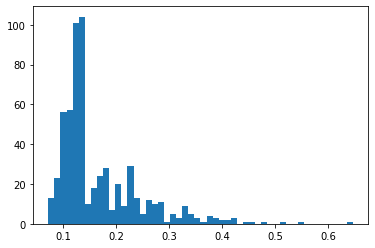

Midfield position mean 0.08585727912713484


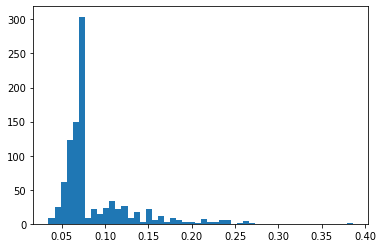

In [275]:
def prob_for_position(position):
    X_example = []
    for player_id in df[df["position"] == position]['player_id'].unique():
        X_example.append([ player_id, position ])
    X_example = one_hot_encoder.transform(X_example)
    ys_pred = [ y[1] for y in model.predict_proba(X_example) ]
    return ys_pred

forward_position_probs = prob_for_position("Forward")
print("Forward position mean", np.mean(forward_position_probs))
plt.hist(forward_position_probs, bins=50)
plt.show()

midfield_position_probs = prob_for_position("Midfield")
print("Midfield position mean", np.mean(midfield_position_probs))
plt.hist(midfield_position_probs, bins=50);

It's interesting to notice that the histograms above remember somewhat a beta distribution, closer to the left side, never smaller than zero, this will be important for us later

But answering our question, yes, Neymar is way above average, as an average forward would score with 17% chance (rouding up). It seems that being Neymar puts a hell lot of weight in the probability to score in a match. 

Remember: this doesn't really mean that Neymar the person alone is way better than everybody else, because many other variables such as "Playing in PSG with good team members" are agregated in "being Neymar", as it's not really possible for us to deconfound this variable right now. On the other hand the position variable (forward, midfield) is pretty  deconfounded as we measure accross all players

So what would be the probability of Neymar scoring, regardless of position?

$$
P(goal|neymar) = \frac{\sum_{i = 1}^{\#positions}{P(goal|neymar,position_i)}}{\#positions}
$$

In [266]:
def prob_for_player_id(player_id):
    X_example = []
    for position in df['position'].unique():
        X_example.append([ player_id, position ])
    X_example = one_hot_encoder.transform(X_example)
    ys_pred = [ y[1] for y in model.predict_proba(X_example) ]
    return np.mean(ys_pred)

prob_for_player_id(neymar_id)

0.18960539993655143

What about Messi?

$$
P(goal | messi )
$$

In [268]:
messi_id = 154
prob_for_player_id(messi_id)

0.21051765637224326

Seems like Messi has a bit higher probability of scoring than Neymar, 21% vs 19%

Those are nice point estimations, but you shouldn't take them as absolute truth, because our data is just a small sample from all matches by those two players (only 2 UEFA championships), as our input is incomplete, how much can we really trust the data we collected?

One alternative approach that helps us with that is building a Bayesian model, where we can estimate distributions over our parameters, as you will see next

# Measuring uncertainty with Bayesian Analysis

Check the other notebook